HW1 note: data_path 通常是kaggle/input/dl1-hw1/DL_HW1 但不知為何KAGGLE有時候會忽略 datasets 名字 dl-HW1

**補交note：更動第3題轉化標籤 ＆＆ 部份結果未顯示的過程**

# **第一題: 1.1**

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from keras.utils import to_categorical
os.chdir("/kaggle/input")
data_path = 'dl-hw1/DL_HW1/fashion/fashion'
data = np.load("dl-hw1/DL_HW1/weights.npy", allow_pickle=True)


In [4]:
# 讀取數據
train_x = np.load(f"{data_path}/train_x.npy")  # 訓練圖片
train_y = np.load(f"{data_path}/train_y.npy")  # 訓練標籤
test_x = np.load(f"{data_path}/test_x.npy")    # 測試圖片
test_y = np.load(f"{data_path}/test_y.npy")    # 測試標籤
# 正規化：將像素值縮放到 0-1
train_x, test_x = train_x / 255.0, test_x / 255.0

# One-hot 編碼標籤
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

train_y_oh = one_hot_encode(train_y)
test_y_oh = one_hot_encode(test_y)

In [5]:
def initialize_weights():
    weights_dict= np.load("dl-hw1/DL_HW1/weights.npy", allow_pickle=True).item()  

    w1 = weights_dict['w1']
    w2 = weights_dict['w2']  
    w3 = weights_dict['w3']
    b1 = weights_dict['b1']  
    b2 = weights_dict['b2']
    b3 = weights_dict['b3']  
    
    return weights_dict 

In [6]:
weights_dict = np.load("dl-hw1/DL_HW1/weights.npy", allow_pickle=True).item()
print("Keys in weights_dict:", weights_dict.keys())  # 檢查有哪些 key

Keys in weights_dict: dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3'])


In [7]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [8]:
def forward_propagation(X, weights, dropout=False):
    w1, b1, w2, b2, w3, b3 = weights.values()

    # 第一層
    Z1 = X @ w1 + b1.T
    A1 = relu(Z1)
    if dropout:
        D1 = (np.random.rand(*A1.shape) > 0.2) / 0.8
        A1 *= D1
    else:
        D1 = None

    # 第二層
    Z2 = A1 @ w2 + b2.T
    A2 = relu(Z2)
    if dropout:
        D2 = (np.random.rand(*A2.shape) > 0.2) / 0.8
        A2 *= D2
    else:
        D2 = None

    # 輸出層
    Z3 = A2 @ w3 + b3.T
    A3 = softmax(Z3)

    return (Z1, A1, D1, Z2, A2, D2, Z3, A3)

In [9]:
def backward_propagation(X, Y, weights, cache):
    w1, b1, w2, b2, w3, b3 = weights.values()
    Z1, A1, D1, Z2, A2, D2, Z3, A3 = cache

    # 計算梯度
    dZ3 = A3 - Y
    dW3 = A2.T @ dZ3 / X.shape[0]
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X.shape[0]

    dA2 = dZ3 @ w3.T
    if D2 is not None: dA2 *= D2
    dZ2 = dA2 * (A2 > 0)
    dW2 = A1.T @ dZ2 / X.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X.shape[0]

    dA1 = dZ2 @ w2.T
    if D1 is not None: dA1 *= D1
    dZ1 = dA1 * (A1 > 0)
    dW1 = X.T @ dZ1 / X.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X.shape[0]

    db1 = db1.reshape(weights["b1"].shape)
    db2 = db2.reshape(weights["b2"].shape)
    db3 = db3.reshape(weights["b3"].shape)
    # 返回梯度
    return {"w1": dW1, "b1": db1, "w2": dW2, "b2": db2, "w3": dW3, "b3": db3}


In [11]:
train_x = train_x.reshape(train_x.shape[0], -1)  # 轉換為 (60000, 784)
test_x = test_x.reshape(test_x.shape[0], -1)     # 轉換為 (10000, 784)


In [12]:
# 訓練模型
def train_model(train_x, train_y, test_x, test_y, weights, learning_rate=0.005, epochs=30, batch_size=200, dropout=True):
    history = {"iter_loss": [], "iter_acc": [], "train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    iterations_per_epoch = train_x.shape[0] // batch_size  # 60000/200 = 300 iterations
    log_interval = 30  # 每 30 個 iterations 記錄一次
    
    print(f"Training started: {epochs} epochs, {iterations_per_epoch} iterations/epoch, logging every {log_interval} iterations")
    
    for epoch in range(epochs):
        for i in range(0, train_x.shape[0], batch_size):
            iteration = epoch * iterations_per_epoch + i // batch_size
            
            # Mini-batch
            X_batch = train_x[i:i + batch_size]
            Y_batch = train_y[i:i + batch_size]

            # 確保 Y_batch 為 one-hot
            if Y_batch.ndim == 1:
                Y_batch = to_categorical(Y_batch, num_classes=10)

            # 前向傳播
            cache = forward_propagation(X_batch, weights, dropout)
            A3 = cache[-1]

            # 損失計算
            loss = -np.mean(np.sum(Y_batch * np.log(A3 + 1e-8), axis=1))
            acc = np.mean(np.argmax(A3, axis=1) == np.argmax(Y_batch, axis=1))

            # 反向傳播
            grads = backward_propagation(X_batch, Y_batch, weights, cache)

            # 更新權重
            for key in weights:
                if key in grads and grads[key] is not None:
                    weights[key] -= learning_rate * grads[key]

            if iteration % log_interval == 0:  # 每 30 個 iterations 記錄一次
                history["iter_loss"].append(loss)
                history["iter_acc"].append(acc)
                
                # 計算訓練和測試準確率
                train_pred = np.argmax(forward_propagation(train_x, weights, dropout=False)[-1], axis=1)
                test_pred = np.argmax(forward_propagation(test_x, weights, dropout=False)[-1], axis=1)

                # 計算訓練和測試損失
                if train_y.ndim == 1:  # 若 train_y 是一維標籤
                    train_loss = -np.mean(np.log(forward_propagation(train_x, weights, dropout=False)[-1][np.arange(len(train_y)), train_y] + 1e-8))
                    test_loss = -np.mean(np.log(forward_propagation(test_x, weights, dropout=False)[-1][np.arange(len(test_y)), test_y] + 1e-8))
                else:  # 若 train_y 是 one-hot
                    train_loss = -np.mean(np.sum(train_y * np.log(forward_propagation(train_x, weights, dropout=False)[-1] + 1e-8), axis=1))
                    test_loss = -np.mean(np.sum(test_y * np.log(forward_propagation(test_x, weights, dropout=False)[-1] + 1e-8), axis=1))

                # 計算訓練和測試準確率
                if train_y.ndim == 1:  # 若 train_y 是一維標籤
                    train_acc = np.mean(train_pred == train_y)
                    test_acc = np.mean(test_pred == test_y)
                else:  # 若 train_y 是 one-hot
                    train_acc = np.mean(train_pred == np.argmax(train_y, axis=1))
                    test_acc = np.mean(test_pred == np.argmax(test_y, axis=1))
                
                history["train_loss"].append(train_loss)
                history["test_loss"].append(test_loss)
                history["train_acc"].append(train_acc)
                history["test_acc"].append(test_acc)
                
                print(f"Epoch {epoch+1}/{epochs}, Iter {iteration}: "
                      f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
                      f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")
    
    return history


In [10]:
def initialize_zero_weights():
    weights_dict = {}

    input_dim = 784  
    hidden_dim1 = 2048
    hidden_dim2 = 512
    output_dim = 10  # 10 類別

    weights_dict['w1'] = np.zeros((input_dim, hidden_dim1))
    weights_dict['b1'] = np.zeros(( hidden_dim1,1))
    weights_dict['w2'] = np.zeros((hidden_dim1, hidden_dim2))
    weights_dict['b2'] = np.zeros(( hidden_dim2,1))
    weights_dict['w3'] = np.zeros((hidden_dim2, output_dim))
    weights_dict['b3'] = np.zeros((output_dim,1))

    return weights_dict



In [11]:
# 讀取原始權重
original_weights = initialize_weights()

# 創建全 0 權重
zero_weights = initialize_zero_weights()

# 訓練原始模型
print("Training model with original weights:")
history_original = train_model(train_x, train_y, test_x, test_y, original_weights)

# 訓練全 0 權重的模型
print("\nTraining model with zero weights:")
history_zero = train_model(train_x, train_y, test_x, test_y, zero_weights)

Training model with original weights:
Training started: 30 epochs, 300 iterations/epoch, logging every 30 iterations
Epoch 1/30, Iter 0: Train Loss=14.2482, Test Loss=14.2696, Train Acc=0.2249, Test Acc=0.2233
Epoch 1/30, Iter 30: Train Loss=4.6828, Test Loss=4.9274, Train Acc=0.7391, Test Acc=0.7251
Epoch 1/30, Iter 60: Train Loss=4.1495, Test Loss=4.3953, Train Acc=0.7648, Test Acc=0.7510
Epoch 1/30, Iter 90: Train Loss=4.2161, Test Loss=4.4371, Train Acc=0.7592, Test Acc=0.7464
Epoch 1/30, Iter 120: Train Loss=4.0645, Test Loss=4.2368, Train Acc=0.7624, Test Acc=0.7518
Epoch 1/30, Iter 150: Train Loss=3.9002, Test Loss=4.1404, Train Acc=0.7648, Test Acc=0.7505
Epoch 1/30, Iter 180: Train Loss=3.9056, Test Loss=4.0876, Train Acc=0.7495, Test Acc=0.7376
Epoch 1/30, Iter 210: Train Loss=3.8898, Test Loss=4.0702, Train Acc=0.7474, Test Acc=0.7363
Epoch 1/30, Iter 240: Train Loss=3.6256, Test Loss=3.7854, Train Acc=0.7473, Test Acc=0.7390
Epoch 1/30, Iter 270: Train Loss=3.3663, Test Los

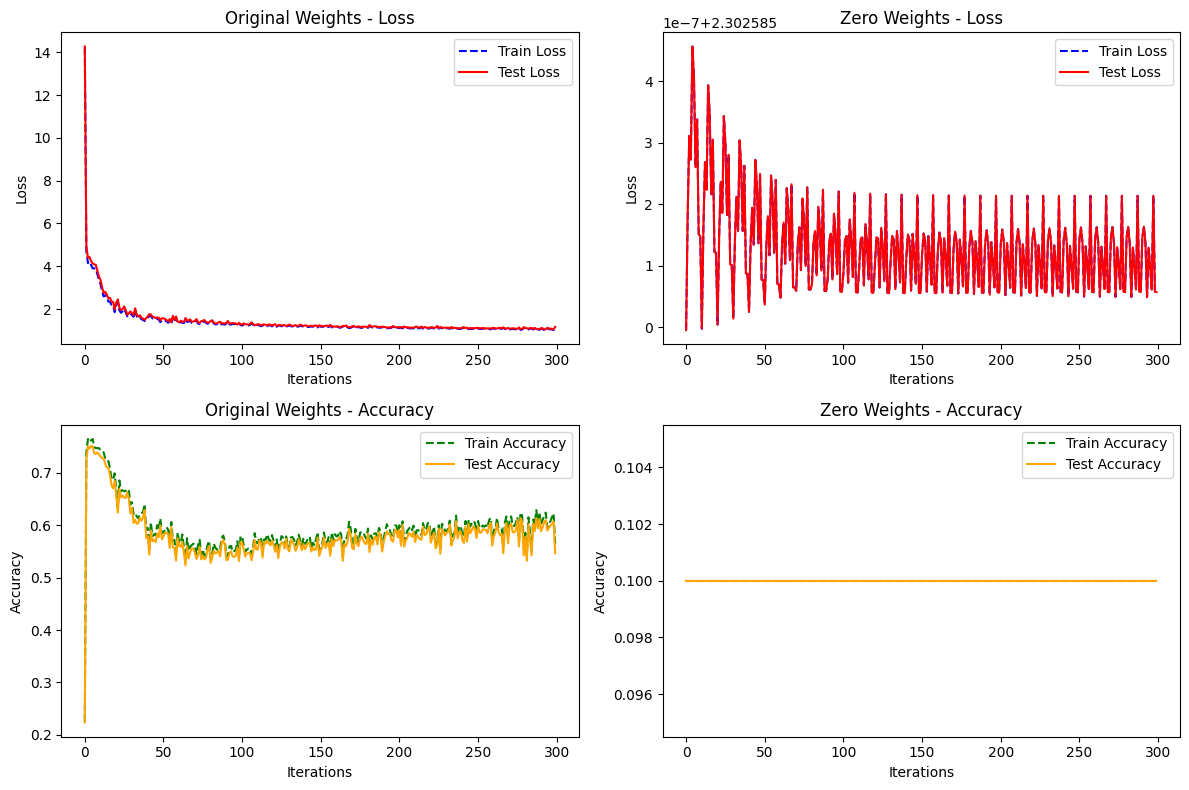

In [12]:
plt.figure(figsize=(12, 8))

# 圖 1: 原始權重的損失 (Train & Test)
plt.subplot(2, 2, 1)
plt.plot(history_original["train_loss"], label="Train Loss", linestyle="dashed", color="blue")
plt.plot(history_original["test_loss"], label="Test Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Original Weights - Loss")

# 圖 2: 零初始化權重的損失 (Train & Test)
plt.subplot(2, 2, 2)
plt.plot(history_zero["train_loss"], label="Train Loss", linestyle="dashed", color="blue")
plt.plot(history_zero["test_loss"], label="Test Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Zero Weights - Loss")

# 圖 3: 原始權重的準確率 (Train & Test)
plt.subplot(2, 2, 3)
plt.plot(history_original["train_acc"], label="Train Accuracy", linestyle="dashed", color="green")
plt.plot(history_original["test_acc"], label="Test Accuracy", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Original Weights - Accuracy")

# 圖 4: 零初始化權重的準確率 (Train & Test)
plt.subplot(2, 2, 4)
plt.plot(history_zero["train_acc"], label="Train Accuracy", linestyle="dashed", color="green")
plt.plot(history_zero["test_acc"], label="Test Accuracy", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Zero Weights - Accuracy")

plt.tight_layout()
plt.show()


1.1 討論

可以看到當所有權重初始化為 0：

所有神經元的輸出都一樣

由於所有的權重都是 0，所以每一層的輸入經過 Z = W⋅X + b 計算後，Z 的值都會一樣（因為 W=0）。

這樣，每個神經元在前向傳播時都會輸出相同的值，導致梯度更新時，它們的梯度也都完全一樣。

梯度對所有神經元相同

由於誤差的梯度（backpropagation）與輸出有關，且所有神經元的輸出都相同，因此所有神經元的梯度也會變得相同。

這導致所有神經元的權重在每個 epoch 內部更新時都保持相同的值，無法學習到有區別的特徵。

Loss 在所有 epochs 之間不變

因為模型無法學習，所以它的預測結果在每個 epoch 都是一樣的，導致 loss 和 accuracy 也不變。

Train Loss 和 Test Loss 完全重疊

這是因為模型的權重完全對稱，沒有學習到數據的特徵，因此在訓練集和測試集上的表現完全一樣。

# **1.2**

Weights keys before update: dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3'])
Epoch 1, Iter 1/300: Train Loss=1.4630, Test Loss=1.4588, Train Acc=0.2037, Test Acc=0.2062
Epoch 1, Iter 31/300: Train Loss=0.4703, Test Loss=0.4897, Train Acc=0.7364, Test Acc=0.7254
Epoch 1, Iter 61/300: Train Loss=0.4120, Test Loss=0.4262, Train Acc=0.7649, Test Acc=0.7576
Epoch 1, Iter 91/300: Train Loss=0.4116, Test Loss=0.4338, Train Acc=0.7591, Test Acc=0.7450
Epoch 1, Iter 121/300: Train Loss=0.3916, Test Loss=0.3999, Train Acc=0.7648, Test Acc=0.7594
Epoch 1, Iter 151/300: Train Loss=0.4000, Test Loss=0.4128, Train Acc=0.7561, Test Acc=0.7478
Epoch 1, Iter 181/300: Train Loss=0.3940, Test Loss=0.4066, Train Acc=0.7455, Test Acc=0.7367
Epoch 1, Iter 211/300: Train Loss=0.3785, Test Loss=0.3888, Train Acc=0.7420, Test Acc=0.7352
Epoch 1, Iter 241/300: Train Loss=0.3635, Test Loss=0.3799, Train Acc=0.7466, Test Acc=0.7331
Epoch 1, Iter 271/300: Train Loss=0.3190, Test Loss=0.3374, Train Acc=0.7477, Test 

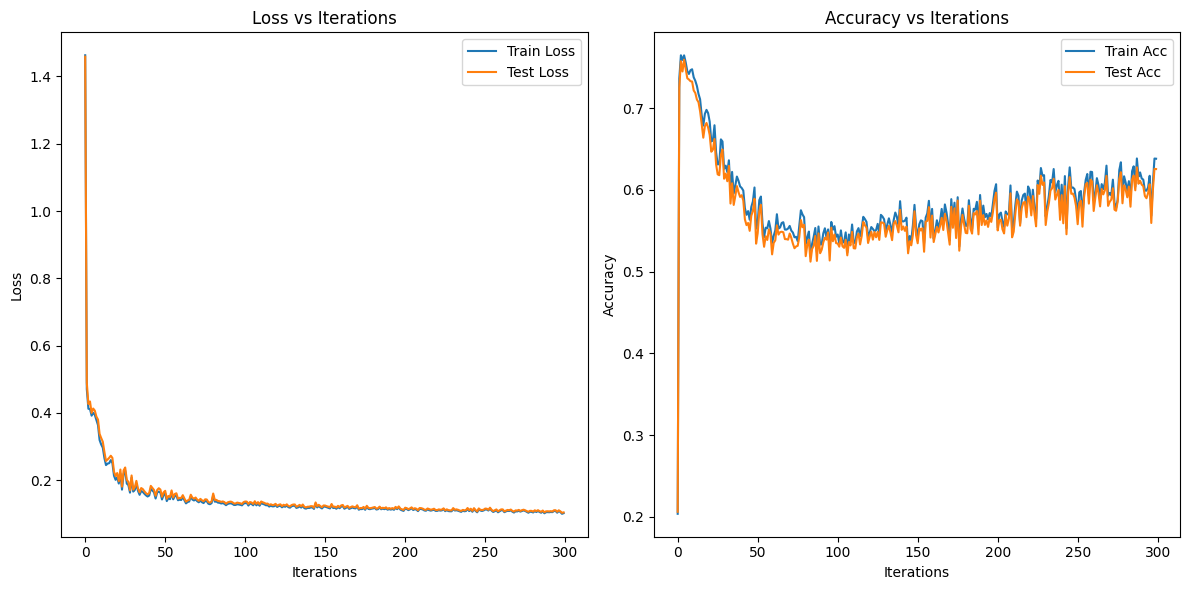

In [13]:
# 訓練模型
def train_model_task_2(train_x, train_y, test_x, test_y, weights, learning_rate=0.005, epochs=30, batch_size=200, dropout=True):
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    iterations_per_epoch = train_x.shape[0] // batch_size  # 60000 / 200 = 300 iterations
    log_interval = 30  # 每 30 個 iterations 記錄一次
    total_iterations = epochs * (iterations_per_epoch // log_interval)  # 300 points for 30 epochs
    
    print("Weights keys before update:", weights.keys())
    
    # 用來存儲每 30 次 iteration 的損失與準確率，後面用於繪圖
    all_train_loss = []
    all_test_loss = []
    all_train_acc = []
    all_test_acc = []
    
    for epoch in range(epochs):
        # Mini-batch SGD
        for i in range(0, train_x.shape[0], batch_size):
            X_batch = train_x[i:i + batch_size]
            Y_batch = train_y[i:i + batch_size]

            # 前向傳播
            cache = forward_propagation(X_batch, weights, dropout)
            A3 = cache[-1]

            # 計算損失
            loss = -np.mean(Y_batch * np.log(A3 + 1e-8))

            # 反向傳播
            grads = backward_propagation(X_batch, Y_batch, weights, cache)

            # 更新權重
            for key in weights:
                if key in grads and grads[key] is not None:
                    weights[key] -= learning_rate * grads[key]
                else:
                    print(f"Warning: '{key}' not found in grads or is None")

            # 每 30 次 iterations 作圖
            if (i // batch_size) % log_interval == 0:
                # 計算訓練和測試準確率
                train_pred = np.argmax(forward_propagation(train_x, weights, dropout=False)[-1], axis=1)
                test_pred = np.argmax(forward_propagation(test_x, weights, dropout=False)[-1], axis=1)

                # 計算訓練和測試損失
                train_loss = -np.mean(train_y * np.log(forward_propagation(train_x, weights, dropout=False)[-1] + 1e-8))
                test_loss = -np.mean(test_y * np.log(forward_propagation(test_x, weights, dropout=False)[-1] + 1e-8))

                # 計算訓練和測試準確率
                train_acc = np.mean(train_pred == np.argmax(train_y, axis=1))
                test_acc = np.mean(test_pred == np.argmax(test_y, axis=1))

                # 保存到 history 和 all 結果
                history["train_loss"].append(train_loss)
                history["test_loss"].append(test_loss)
                history["train_acc"].append(train_acc)
                history["test_acc"].append(test_acc)

                all_train_loss.append(train_loss)
                all_test_loss.append(test_loss)
                all_train_acc.append(train_acc)
                all_test_acc.append(test_acc)

                print(f"Epoch {epoch+1}, Iter {i//batch_size+1}/{iterations_per_epoch}: "
                      f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
                      f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

    # 訓練完成後繪製最終的 300 個點
    plt.figure(figsize=(12, 6))
    
    # 訓練和測試損失
    plt.subplot(1, 2, 1)
    plt.plot(range(len(all_train_loss)), all_train_loss, label="Train Loss")
    plt.plot(range(len(all_test_loss)), all_test_loss, label="Test Loss")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Iterations')

    # 訓練和測試準確率
    plt.subplot(1, 2, 2)
    plt.plot(range(len(all_train_acc)), all_train_acc, label="Train Acc")
    plt.plot(range(len(all_test_acc)), all_test_acc, label="Test Acc")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Iterations')

    plt.tight_layout()
    plt.show()
    
    return history
history_task_2 = train_model_task_2(train_x, train_y_oh, test_x, test_y_oh, initialize_weights())

1.2討論

使用 Dropout 進行訓練與題1 類似，但波動較大。

與 第一題 相比，準確度曲線波動較大。

Dropout 後的影響：
訓練 Loss 變小 ，代表 Dropout 沒有明顯讓模型變得難學習（可能是因為 Dropout 率較低，影響有限）。

測試 Loss 也變小 ，顯示 Dropout 有助於模型泛化，但提升幅度不大，代表原始模型的 overfitting 可能不嚴重。

訓練準確率略微上升 ，但測試準確率的提升更明顯 。

這表示 Dropout 幫助模型減少了 overfitting，讓模型更能泛化到測試數據。

# **1.3** 

Weights keys before update: dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3'])
Epoch 1, Iter 1/300: Train Loss=1.5622, Test Loss=1.5565, Train Acc=0.1503, Test Acc=0.1525
Epoch 1, Iter 31/300: Train Loss=0.5047, Test Loss=0.5304, Train Acc=0.7135, Test Acc=0.7004
Epoch 1, Iter 61/300: Train Loss=0.5125, Test Loss=0.5338, Train Acc=0.7048, Test Acc=0.6947
Epoch 1, Iter 91/300: Train Loss=0.4545, Test Loss=0.4782, Train Acc=0.7321, Test Acc=0.7196
Epoch 1, Iter 121/300: Train Loss=0.4173, Test Loss=0.4366, Train Acc=0.7450, Test Acc=0.7349
Epoch 1, Iter 151/300: Train Loss=0.4111, Test Loss=0.4363, Train Acc=0.7420, Test Acc=0.7273
Epoch 1, Iter 181/300: Train Loss=0.3867, Test Loss=0.4054, Train Acc=0.7519, Test Acc=0.7405
Epoch 1, Iter 211/300: Train Loss=0.3826, Test Loss=0.4116, Train Acc=0.7419, Test Acc=0.7263
Epoch 1, Iter 241/300: Train Loss=0.3585, Test Loss=0.3801, Train Acc=0.7466, Test Acc=0.7351
Epoch 1, Iter 271/300: Train Loss=0.3520, Test Loss=0.3711, Train Acc=0.7429, Test 

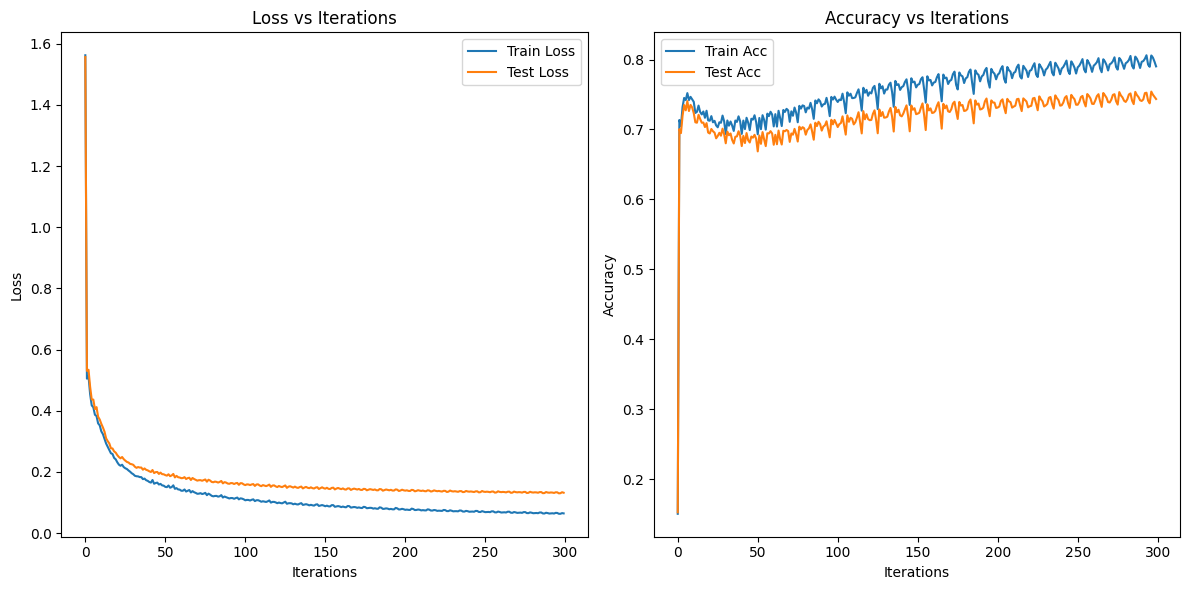

In [13]:
# 訓練模型
def train_model_task_3(train_x, train_y, test_x, test_y, weights, learning_rate=0.005, epochs=30, batch_size=200):
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    iterations_per_epoch = train_x.shape[0] // batch_size  # 60000 / 200 = 300 iterations
    log_interval = 30  # 每 30 個 iterations 記錄一次
    total_iterations = epochs * (iterations_per_epoch // log_interval)  # 300 points for 30 epochs
    
    print("Weights keys before update:", weights.keys())
    
    # 用來存儲每 30 次 iteration 的損失與準確率，後面用於繪圖
    all_train_loss = []
    all_test_loss = []
    all_train_acc = []
    all_test_acc = []
    
    for epoch in range(epochs):
        # Mini-batch SGD with reshuffling the data
        indices = list(range(train_x.shape[0]))
        random.seed(42)  # Set seed for reproducibility
        random.shuffle(indices)  # Shuffle indices for each epoch
        
        for i in range(0, len(indices), batch_size):
            # Create mini-batches using shuffled data
            batch_indices = indices[i:i + batch_size]
            X_batch = train_x[batch_indices]
            Y_batch = train_y[batch_indices]

            # 前向傳播 (without dropout)
            cache = forward_propagation(X_batch, weights, dropout=False)
            A3 = cache[-1]

            # 計算損失
            loss = -np.mean(Y_batch * np.log(A3 + 1e-8))

            # 反向傳播
            grads = backward_propagation(X_batch, Y_batch, weights, cache)

            # 更新權重
            for key in weights:
                if key in grads and grads[key] is not None:
                    weights[key] -= learning_rate * grads[key]
                else:
                    print(f"Warning: '{key}' not found in grads or is None")

            # 每 30 次 iterations 記錄一次
            if (i // batch_size) % log_interval == 0:
                # 計算訓練和測試準確率
                train_pred = np.argmax(forward_propagation(train_x, weights, dropout=False)[-1], axis=1)
                test_pred = np.argmax(forward_propagation(test_x, weights, dropout=False)[-1], axis=1)

                # 計算訓練和測試損失
                train_loss = -np.mean(train_y * np.log(forward_propagation(train_x, weights, dropout=False)[-1] + 1e-8))
                test_loss = -np.mean(test_y * np.log(forward_propagation(test_x, weights, dropout=False)[-1] + 1e-8))

                # 計算訓練和測試準確率
                train_acc = np.mean(train_pred == np.argmax(train_y, axis=1))
                test_acc = np.mean(test_pred == np.argmax(test_y, axis=1))

                # 保存到 history 和 all 結果
                history["train_loss"].append(train_loss)
                history["test_loss"].append(test_loss)
                history["train_acc"].append(train_acc)
                history["test_acc"].append(test_acc)

                all_train_loss.append(train_loss)
                all_test_loss.append(test_loss)
                all_train_acc.append(train_acc)
                all_test_acc.append(test_acc)

                print(f"Epoch {epoch+1}, Iter {i//batch_size+1}/{iterations_per_epoch}: "
                      f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
                      f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")
        
    # 訓練完成後繪製最終的 300 個點
    plt.figure(figsize=(12, 6))
    
    # 訓練和測試損失
    plt.subplot(1, 2, 1)
    plt.plot(range(len(all_train_loss)), all_train_loss, label="Train Loss")
    plt.plot(range(len(all_test_loss)), all_test_loss, label="Test Loss")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Iterations')

    # 訓練和測試準確率
    plt.subplot(1, 2, 2)
    plt.plot(range(len(all_train_acc)), all_train_acc, label="Train Acc")
    plt.plot(range(len(all_test_acc)), all_test_acc, label="Test Acc")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Iterations')

    plt.tight_layout()
    plt.show()

    return history

# 使用模型
history_task_3 = train_model_task_3(train_x, train_y_oh, test_x, test_y_oh, initialize_weights())

1.3 討論
訓練 Loss 進一步下降 ，代表隨機打亂資料有助於更均勻地學習不同的樣本。
訓練準確率顯著上升 ，表示 Reshuffle 讓模型學習得更好

測試 Loss 比原模型低但稍大於 DROPOUT，測試準確率相較 1.2 提升幅度較小 ：
可能是因為Reshuffle 讓模型學習更加穩定，但如果 mini-batch 內的樣本分布變化過大，可能會影響泛化能力。
如果訓練 Loss 下降太快，模型可能更接近 overfitting。





# **第2題    2.1&2.2**



In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
os.chdir("/kaggle/input")
data_path = 'dl-hw1/DL_HW1/flower/flower'

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # 資料夾名稱當作類別，轉成 int
        class_dirs = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: int(cls_name) - 1 for cls_name in class_dirs}  # 類別從 0 開始

        for cls_name in class_dirs:
            cls_path = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_path):
                if fname.endswith(('jpg', 'jpeg', 'png')):
                    self.image_paths.append(os.path.join(cls_path, fname))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label
        


In [16]:
class TestImageDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted([
            os.path.join(test_dir, fname)
            for fname in os.listdir(test_dir)
            if fname.endswith(('jpg', 'jpeg', 'png'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image_name = os.path.basename(self.image_paths[idx])
        return image, image_name


In [17]:
# 設定圖像增強與正規化的transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 訓練集
train_data = datasets.ImageFolder(root=f"{data_path}/train", transform=transform)

# 測試集（自定義處理）
test_data = TestImageDataset(test_dir=f"{data_path}/test", transform=transform)


# 創建資料加載器
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [18]:
# 訓練模型

def train_model(model, train_loader, epochs=100, validation_split=0.2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 切分訓練數據為訓練集和驗證集
    train_size = int((1 - validation_split) * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

    # 創建新的數據加載器
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_loader.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=train_loader.batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # 訓練損失與準確度
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        # 驗證模型
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # 驗證損失與準確度
        val_losses.append(running_loss / len(val_loader))
        val_acc.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Train Accuracy: {train_acc[-1]}, Validation Accuracy: {val_acc[-1]}")

    return train_losses, val_losses, train_acc, val_acc

In [19]:

# 繪製學習曲線
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, title="Learning Curves"):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title(f"{title} - Accuracy")
    
    plt.show()




In [10]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 102)
    
    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x


In [11]:
class CNN_LN(nn.Module):
    def __init__(self):
        super(CNN_LN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.ln1 = nn.LayerNorm([64, 16, 16])  # 修正為 conv1 後的輸出形狀
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.ln2 = nn.LayerNorm([128, 8, 8])  # 修正為 conv2 後的輸出形狀
        self.fc1 = nn.Linear(128 * 8 * 8, 102)  # 修正為 8*8 因為經過兩次pooling
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [batch, 64, 16, 16]
        x = self.ln1(x)  # 現在輸入形狀與 LayerNorm 定義匹配
        x = self.pool2(torch.relu(self.conv2(x)))  # [batch, 128, 8, 8]
        x = self.ln2(x)  # 現在輸入形狀與 LayerNorm 定義匹配
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [12]:
# 創建和訓練帶有 Batch Normalization 和 Layer Normalization 的模型
model_bn = CNN_BN()

model_ln = CNN_LN()

In [14]:

train_losses_bn, val_losses_bn, train_acc_bn, val_acc_bn = train_model(model_bn, train_loader, epochs=30)

Epoch 1/30, Train Loss: 2.490455764326556, Validation Loss: 2.5008268420760698, Train Accuracy: 0.5311149524632671, Validation Accuracy: 0.5488331892826275
Epoch 2/30, Train Loss: 0.6917069363696822, Validation Loss: 2.1814655564926766, Train Accuracy: 0.8234658599827139, Validation Accuracy: 0.5955056179775281
Epoch 3/30, Train Loss: 0.29035295081035845, Validation Loss: 2.4938936040208146, Train Accuracy: 0.9185393258426966, Validation Accuracy: 0.554019014693172
Epoch 4/30, Train Loss: 0.1171715086486576, Validation Loss: 2.464031196929313, Train Accuracy: 0.9656439066551427, Validation Accuracy: 0.5652549697493517
Epoch 5/30, Train Loss: 0.07261557832424496, Validation Loss: 2.4782588530231164, Train Accuracy: 0.9781763180639585, Validation Accuracy: 0.5877268798617113
Epoch 6/30, Train Loss: 0.049086796347822606, Validation Loss: 2.4071340883100354, Train Accuracy: 0.9868193604148661, Validation Accuracy: 0.5894554883318929
Epoch 7/30, Train Loss: 0.045973780218527875, Validation 

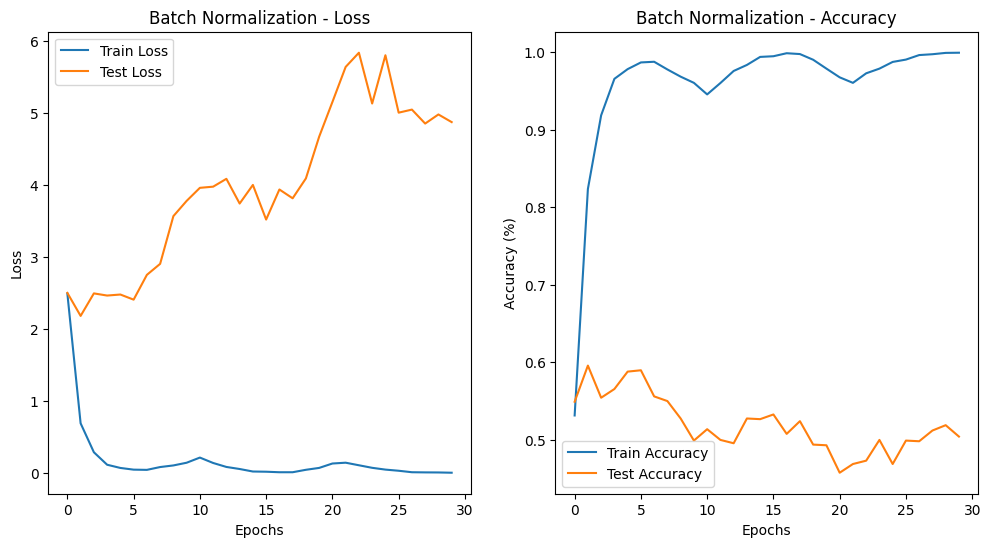

In [16]:
# 繪製 Batch Normalization 的學習曲線
plot_learning_curve(train_losses_bn, val_losses_bn, train_acc_bn, val_acc_bn, title="Batch Normalization")

In [17]:
train_losses_ln, val_losses_ln, train_acc_ln, val_acc_ln = train_model(model_ln, train_loader, epochs=30)


Epoch 1/30, Train Loss: 4.117552334686805, Validation Loss: 3.0888888835906982, Train Accuracy: 0.17372515125324114, Validation Accuracy: 0.28694900605012963
Epoch 2/30, Train Loss: 2.077746268798565, Validation Loss: 2.8515030822238407, Train Accuracy: 0.4786084701815039, Validation Accuracy: 0.3707865168539326
Epoch 3/30, Train Loss: 0.9346365881377253, Validation Loss: 2.9449728791778154, Train Accuracy: 0.7322817631806395, Validation Accuracy: 0.40881590319792566
Epoch 4/30, Train Loss: 0.3494654797788324, Validation Loss: 3.146120715785671, Train Accuracy: 0.8984442523768367, Validation Accuracy: 0.41140881590319794
Epoch 5/30, Train Loss: 0.10861515104770661, Validation Loss: 3.2254926288450085, Train Accuracy: 0.9693171996542783, Validation Accuracy: 0.4407951598962835
Epoch 6/30, Train Loss: 0.026885154040466094, Validation Loss: 3.1931611686139494, Train Accuracy: 0.993733794295592, Validation Accuracy: 0.44684528954191877
Epoch 7/30, Train Loss: 0.004426277625968616, Validati

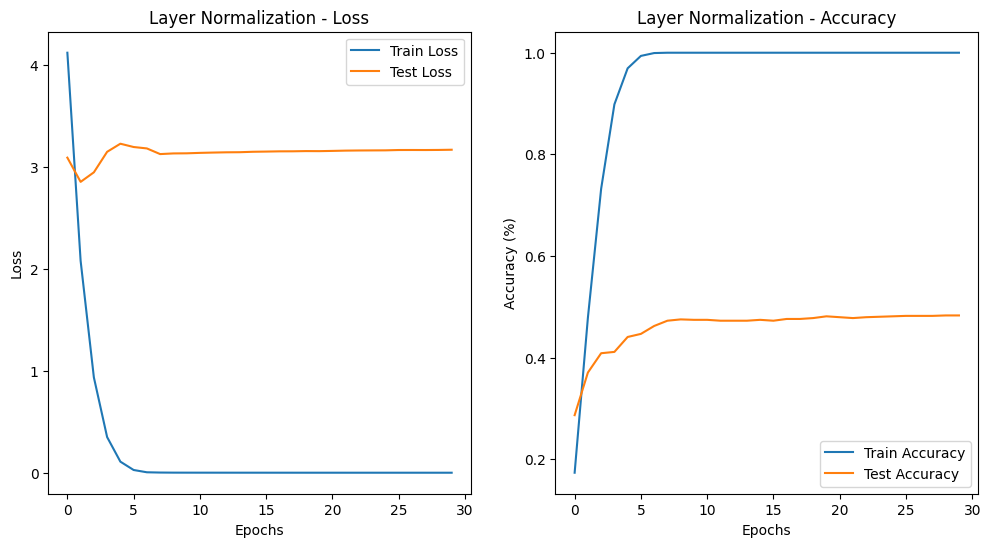

In [18]:
#  Layer Normalization 的學習曲線
plot_learning_curve(train_losses_ln, val_losses_ln, train_acc_ln, val_acc_ln, title="Layer Normalization")

# 訓練結果分析

1. Layer Normalization 結果：
Train Accuracy 快速趨近 100%，Train Loss 幾乎為 0。

Test Accuracy 約停在 47~48% 附近，Test Loss 平穩但偏高。

代表模型在訓練集上完全學會了，但在驗證集（val set）上沒辦法泛化，很明顯有 overfitting現象。

2. Batch Normalization 結果：
Train Accuracy 同樣很高（接近 100%）。

Test Accuracy 不穩定，呈現震盪下降，Test Loss 明顯升高。

代表模型在訓練後期變得 非常不穩定，可能是爆炸或梯度震盪（training instability），也就是：

模型學到了錯誤的模式。

或某層參數學習率過高導致 batch norm 參數不穩。



In [20]:

# 創建並訓練 ResNet 模型
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.mean([2, 3])  # Global average pooling
        out = self.fc(out)
        return out

In [7]:

resnet_model = ResNet(BasicBlock, [2, 2, 2, 2])
train_losses_resnet, val_losses_resnet, train_acc_resnet, val_acc_resnet = train_model(resnet_model, train_loader)
        
        

Epoch 1/100, Train Loss: 3.9385008614638757, Validation Loss: 3.6919986428441227, Train Accuracy: 0.09982713915298184, Validation Accuracy: 0.10112359550561797
Epoch 2/100, Train Loss: 3.3154958478335677, Validation Loss: 3.153743112409437, Train Accuracy: 0.17480553154710457, Validation Accuracy: 0.19101123595505617
Epoch 3/100, Train Loss: 2.9837478374612743, Validation Loss: 2.920755605439882, Train Accuracy: 0.23984442523768368, Validation Accuracy: 0.2541054451166811
Epoch 4/100, Train Loss: 2.6585909004869133, Validation Loss: 2.622648564544884, Train Accuracy: 0.2945116681071737, Validation Accuracy: 0.3180639585133967
Epoch 5/100, Train Loss: 2.3400971692183923, Validation Loss: 2.3904154365127153, Train Accuracy: 0.3656006914433881, Validation Accuracy: 0.36387208297320656
Epoch 6/100, Train Loss: 2.092739147975527, Validation Loss: 2.2815999404804126, Train Accuracy: 0.4161624891961971, Validation Accuracy: 0.39671564390665515
Epoch 7/100, Train Loss: 1.8736148266956725, Vali

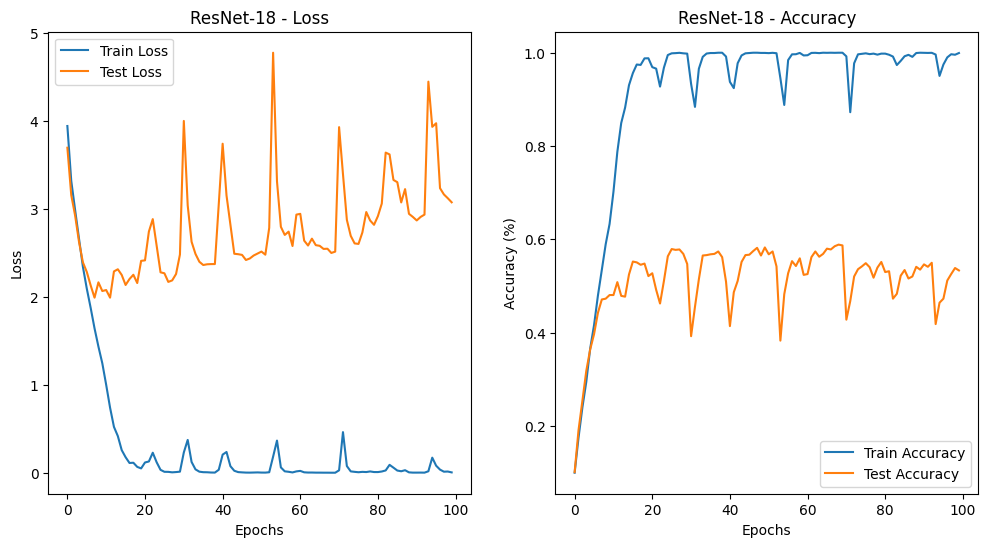

In [8]:
# 繪製學習曲線
plot_learning_curve(train_losses_resnet, val_losses_resnet, train_acc_resnet, val_acc_resnet, title="ResNet-18")


In [21]:
class ResNetNoResidual(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNetNoResidual, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer_no_residual(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer_no_residual(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer_no_residual(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer_no_residual(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer_no_residual(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.mean([2, 3])  # Global average pooling
        out = self.fc(out)
        return out

# 創建並訓練無殘差的 ResNet 模型
resnet_no_residual_model = ResNetNoResidual(BasicBlock, [2, 2, 2, 2])
train_losses_resnet_no, val_losses_resnet_no, train_acc_resnet_no, val_acc_resnet_no = train_model(resnet_no_residual_model, train_loader, epochs=100)


Epoch 1/100, Train Loss: 3.8929627944683207, Validation Loss: 3.6062107859431087, Train Accuracy: 0.11192739844425238, Validation Accuracy: 0.14001728608470182
Epoch 2/100, Train Loss: 3.2765723392881196, Validation Loss: 3.158806897498466, Train Accuracy: 0.17718236819360414, Validation Accuracy: 0.1979256698357822
Epoch 3/100, Train Loss: 2.942735293815876, Validation Loss: 3.029186351879223, Train Accuracy: 0.23811581676750215, Validation Accuracy: 0.23595505617977527
Epoch 4/100, Train Loss: 2.608046217622428, Validation Loss: 3.1376901446162044, Train Accuracy: 0.3165514261019879, Validation Accuracy: 0.22385479688850476
Epoch 5/100, Train Loss: 2.3444879408540396, Validation Loss: 2.371451442306106, Train Accuracy: 0.36430423509075194, Validation Accuracy: 0.36041486603284356
Epoch 6/100, Train Loss: 2.0628914446666324, Validation Loss: 2.6591974464622705, Train Accuracy: 0.4308556611927398, Validation Accuracy: 0.3526361279170268
Epoch 7/100, Train Loss: 1.8890499287638172, Vali

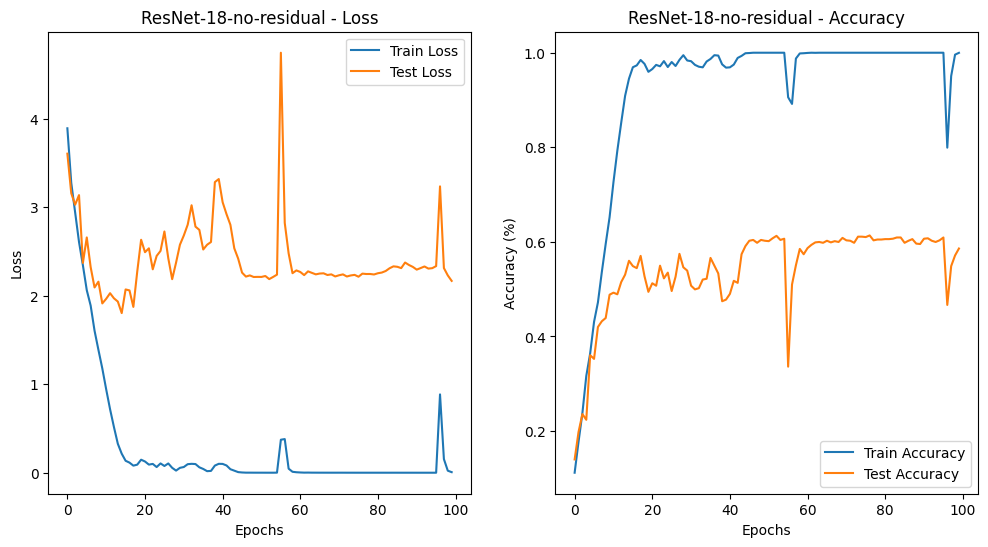

In [22]:
plot_learning_curve(train_losses_resnet_no, val_losses_resnet_no, train_acc_resnet_no, val_acc_resnet_no, title="ResNet-18-no-residual")

# **RESNET有無殘差分析比較**

In [ ]:
1. 訓練與測試損失 (Loss)
ResNet-18 (有殘差)

訓練損失迅速下降並保持較低。

測試損失在前期下降，但後期波動較大，表明一定程度的過擬合。

ResNet-18-no-residual (無殘差)

訓練損失同樣下降，但較有殘差的 ResNet 緩慢。

測試損失下降後呈現較明顯的波動，並且整體損失較高，顯示泛化能力較差。

2. 訓練與測試準確度 (Accuracy)
ResNet-18 (有殘差)

訓練準確率迅速上升並接近 100%，顯示模型學習能力強。

測試準確率約在 60% 左右，但在後期略有下降，可能有過擬合現象。

ResNet-18-no-residual (無殘差)

訓練準確率上升較慢，但仍能達到 100%。

測試準確率比有殘差的模型低，約在 50-60% 之間，且波動較大，顯示模型泛化能力不足。

結論
有殘差的 ResNet-18 訓練較快，測試準確率較穩定，且泛化能力更好。

無殘差的 ResNet-18 訓練較慢，測試損失較高，顯示網路較難學習深層特徵。

無殘差模型的準確度波動較大，說明梯度可能在深層網路中消失，使學習變得困難。


# **第3題**

In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np


data_path = '/kaggle/input/dl-hw1/DL_HW1/flower/flower'

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # 資料夾名稱當作類別，轉成 int
        class_dirs = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: int(cls_name) - 1 for cls_name in class_dirs}  # 類別從 0 開始

        for cls_name in class_dirs:
            cls_path = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_path):
                if fname.endswith(('jpg', 'jpeg', 'png')):
                    self.image_paths.append(os.path.join(cls_path, fname))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [12]:
class TestImageDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted([
            os.path.join(test_dir, fname)
            for fname in os.listdir(test_dir)
            if fname.endswith(('jpg', 'jpeg', 'png'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image_name = os.path.basename(self.image_paths[idx])
        return image, image_name


In [13]:
# --- 資料增強與預處理 ---
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = CustomImageDataset(f"{data_path}/train", transform=train_transform)
test_dataset = TestImageDataset(f"{data_path}/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 檢查資料加載器
for images, labels in train_loader:
    print(images.size(), labels.size())  # 確認圖片和標籤的尺寸
    break


torch.Size([32, 3, 64, 64]) torch.Size([32])


In [14]:
# 繪製學習曲線
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, title="Learning Curves"):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title(f"{title} - Accuracy")
    
    plt.show()

In [15]:
from torch.cuda.amp import GradScaler, autocast
import random

def mixup_data(x, y, alpha=1.0):
    ''' MixUp augmentation '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [16]:
def train_model(model, train_loader, epochs=30, validation_split=0.2, batch_size=32, use_mixup=True, mixup_alpha=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    scaler = GradScaler()  # 用於 AMP
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    # 切分訓練與驗證
    train_size = int((1 - validation_split) * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)

            with autocast():  # 混合精度
                outputs = model(inputs)
                if use_mixup:
                    loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                else:
                    loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            if use_mixup:
                correct_train += (lam * predicted.eq(targets_a).sum().item()
                                 + (1 - lam) * predicted.eq(targets_b).sum().item())
            else:
                correct_train += predicted.eq(labels).sum().item()

            total_train += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_acc.append(correct_train / total_train)

        # 驗證階段
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(total_val_loss / len(val_loader))
        val_acc.append(correct_val / total_val)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]*100:.2f}% | "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_acc[-1]*100:.2f}%")

    return train_losses, val_losses, train_acc, val_acc


In [17]:
# 構建一個 Squeeze-and-Excitation (SE) 區塊，用於自動學習通道的重要性
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        out = self.global_avg_pool(x).view(batch, channels)
        out = self.fc(out).view(batch, channels, 1, 1)
        return x * out
        
# 基礎殘差區塊（BasicBlock）加入了 SE 模組與 GELU 激活
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act = nn.GELU()
        self.downsample = downsample
        self.se = SEBlock(out_channels)

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += identity
        out = self.act(out)
        return out

# 整體 ResNet 架構定義
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.act = nn.GELU()

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [18]:
resnet_model = ResNet(BasicBlock, [2, 2, 2, 2])  # 自己的 SE-ResNet
train_losses, val_losses, train_acc, val_acc = train_model(
    resnet_model, train_loader,
    epochs=50, use_mixup=True, mixup_alpha=0.4  # 啟用混合精度 + MixUp
)

<ipython-input-16-c6cdcfb9f10a>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # 用於 AMP
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-16-c6cdcfb9f10a>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # 混合精度
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
<ipython-input-16-c6cdcfb9f10a>:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train Loss: 4.2295, Train Acc: 6.32% | Validation Loss: 3.8329, Validation Acc: 11.24%
Epoch 2/50 | Train Loss: 3.8820, Train Acc: 10.34% | Validation Loss: 3.4355, Validation Acc: 15.82%
Epoch 3/50 | Train Loss: 3.6665, Train Acc: 14.72% | Validation Loss: 3.2512, Validation Acc: 19.62%
Epoch 4/50 | Train Loss: 3.5511, Train Acc: 17.46% | Validation Loss: 3.3130, Validation Acc: 16.59%
Epoch 5/50 | Train Loss: 3.4576, Train Acc: 19.37% | Validation Loss: 2.9622, Validation Acc: 25.41%
Epoch 6/50 | Train Loss: 3.2403, Train Acc: 23.22% | Validation Loss: 2.8409, Validation Acc: 26.97%
Epoch 7/50 | Train Loss: 3.2245, Train Acc: 24.41% | Validation Loss: 2.8236, Validation Acc: 27.74%
Epoch 8/50 | Train Loss: 3.1797, Train Acc: 26.13% | Validation Loss: 2.5390, Validation Acc: 34.57%
Epoch 9/50 | Train Loss: 3.0681, Train Acc: 28.96% | Validation Loss: 2.6934, Validation Acc: 31.03%
Epoch 10/50 | Train Loss: 2.9877, Train Acc: 30.30% | Validation Loss: 2.4870, Validation Ac

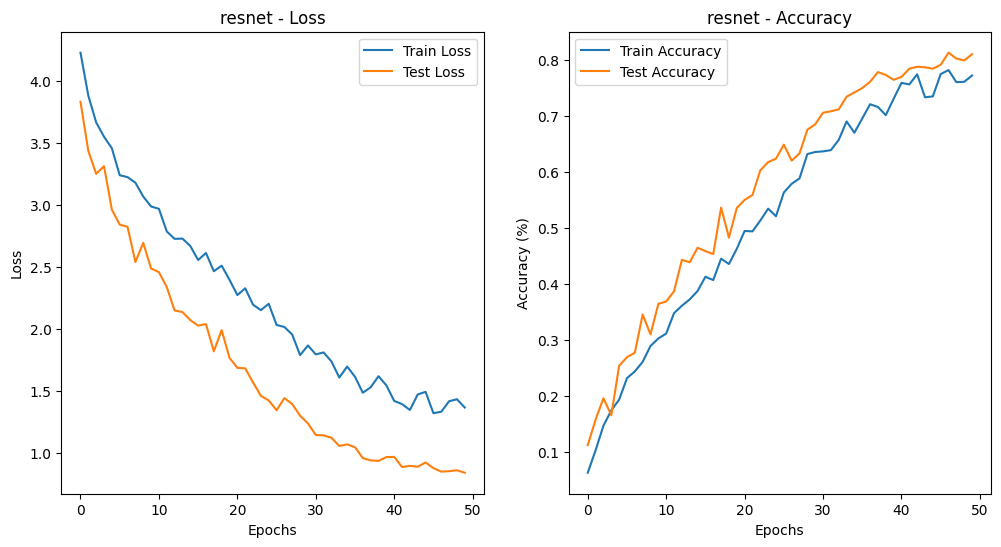

In [19]:
plot_learning_curve(train_losses, val_losses, train_acc, val_acc, title="resnet")

In [42]:
import json
import pandas as pd
import torch
from tqdm import tqdm  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_image_filenames = []  # 定義檔案名列表
# 讀取 JSON 檔案，建立標籤對應
with open(f"{data_path}/cat_to_name.json", 'r') as f:
    cat_to_name = json.load(f)
class_to_idx = train_dataset.class_to_idx               # e.g., {"21": 0, ..., "102": 101}
idx_to_class = {v: k for k, v in class_to_idx.items()} # e.g., {0: "21", ..., 101: "102"}
# Set model to eval mode
resnet_model.eval()
results = []
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = resnet_model(images)
        _, preds = torch.max(outputs, 1)  # Get index of highest score
        for filename, pred in zip(filenames, preds):
            class_idx = pred.item()
            original_class_id = idx_to_class[class_idx]
            category = cat_to_name.get(original_class_id, "Unknown")
            results.append({"ID": filename, "category": category})
            test_image_filenames.append(filename)  # 保存檔案名

100%|██████████| 47/47 [01:07<00:00,  1.43s/it]


In [43]:
if len(test_image_filenames) != len(results):
    print(f"⚠️ 錯誤：test_image_filenames ({len(test_image_filenames)}) 和 results ({len(results)}) 長度不匹配！")
else:
    # 使用 results 中的 'ID' 和 'category' 來生成 CSV
    submission = pd.DataFrame(results)  # 'results' 已經包含了 'ID' 和 'category' 這些資料
    submission = submission[['ID', 'category']]  # 確保 CSV 文件中只包含 'ID' 和 'category' 欄位

    # 儲存為 CSV
    submission.to_csv("/kaggle/working/submission.csv", index=False)
    print("✅ submission.csv 已成功儲存！")


✅ submission.csv 已成功儲存！
